[View in Colaboratory](https://colab.research.google.com/github/pilipolio/learn-pytorch/blob/master/201804_TSNE.ipynb)


# Stochastic neighbour embedding

 * http://lvdmaaten.github.io/tsne
 * [Original article](http://jmlr.csail.mit.edu/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) and author [presentation video](https://www.youtube.com/watch?v=RJVL80Gg3lA)

Approximating a conditional probability distribution by learning embeddings $y_i$ of each data points
$$ p_{j|i} \approx q_{j|i} = \frac{ \exp ( - || y_i - y_j  ||^2) }{ \sum_{k\neq i} \exp ( - || y_i - y_k  ||^2) }$$
    

In [1]:
! pip install torch
import torch
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

torch.__version__

'0.4.0'

## Toy model

Transition probabilities between 3 states

In [2]:
n = 3
d = 2

points_to_clusters = [0, 1, 2]

p_ij = np.array([
    [.3, .6, .1],
     [.3, .4, .3],
     [.1, .6, .3]])

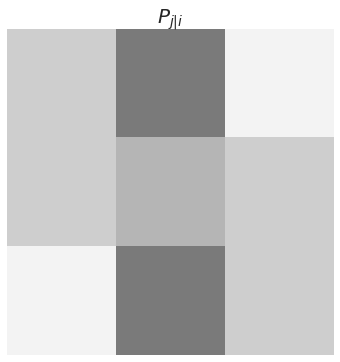

In [3]:
def plot_matrix(probability_matrix, ax=None, title=None, cmap='Greys', **kwargs):
    if ax is None:
        f, ax = plt.subplots(1, figsize=(6, 6))
    ax.imshow(probability_matrix, cmap=cmap, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])
    if title is not None:
        ax.set_title(title, fontsize=20)


plot_matrix(p_ij, title='$P_{j|i}$', vmin=0, vmax=1)

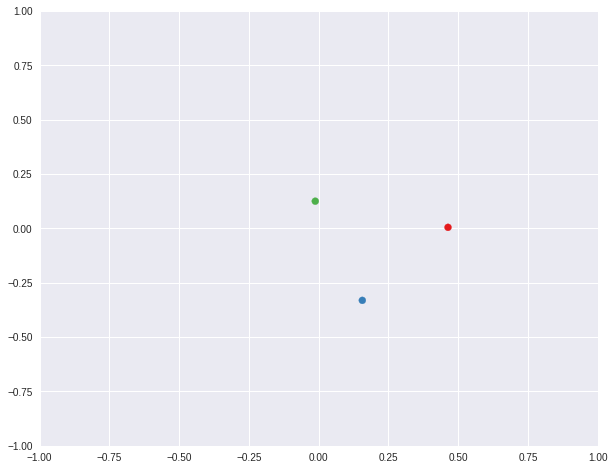

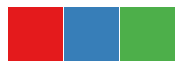

In [4]:
import seaborn as sns
from matplotlib.colors import ListedColormap

y_i = np.random.normal(scale=.25, size=(n, d))

def plot(y_i, points_to_clusters, ax=None, marker='o', palette=None):
    if palette is None:
      palette = sns.color_palette("Set1", np.max(points_to_clusters) + 1)
    cmap = ListedColormap(palette)
    if ax is None:
        f, ax = plt.subplots(figsize=(10, 8))
        sns.palplot(palette)

    ax.scatter(*y_i.T, c=points_to_clusters, marker=marker, cmap=cmap)
    if y_i.max() < 1 and y_i.min() > -1:
      ax.set_xlim([-1, 1]); ax.set_ylim([-1, 1]);
    return ax

plot(y_i, points_to_clusters);

In [5]:
# Numpy broadcasting to perform cartesian product of nxn euclidean distances
# https://stackoverflow.com/a/37903795/230286

# (n x 1 x d) - (n x d) -> (n x n x d)
squared_distances_i_j_k = np.power(y_i[:, np.newaxis, :] - y_i, 2)
pairwise_squared_distances_i_j = squared_distances_i_j_k.sum(axis=2)

pairwise_squared_distances_i_j

array([[0.        , 0.20710729, 0.24079873],
       [0.20710729, 0.        , 0.2365094 ],
       [0.24079873, 0.2365094 , 0.        ]])

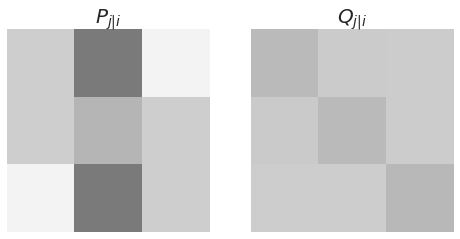

In [6]:
unnormalized_q_i_j = np.exp(-pairwise_squared_distances_i_j)
q_i_j = unnormalized_q_i_j / unnormalized_q_i_j.sum(axis=1)

f, (left, right) = plt.subplots(1, 2, figsize=(8, 8))
plot_matrix(p_ij, ax=left, title='$P_{j|i}$', vmin=0, vmax=1)
plot_matrix(q_i_j, ax=right, title='$Q_{j|i}$', vmin=0, vmax=1)


### Pytorch equivalent

In [7]:
import torch
import torch.autograd
from torch.autograd import Variable

In [8]:
def pairwise_squared_distances(y_i: torch.Tensor):
    # (n x 1 x d) - (n x d) -> (n x n x d)
    squared_distances_ijk = (y_i[:, None, :] - y_i) ** 2
    pairwise_squared_distances_ij = squared_distances_ijk.sum(2)    
    return pairwise_squared_distances_ij

pairwise_squared_distances(torch.from_numpy(y_i))

tensor([[ 0.0000,  0.2071,  0.2408],
        [ 0.2071,  0.0000,  0.2365],
        [ 0.2408,  0.2365,  0.0000]], dtype=torch.float64)

In [9]:
def approximated_probs(embeddings_i: torch.Tensor):
    pairwise_squared_distances_ij = pairwise_squared_distances(embeddings_i)
    unnormalized_q_ij = (-pairwise_squared_distances_ij).exp()
    q_ij = unnormalized_q_ij / unnormalized_q_ij.sum(1)

    return q_ij

approximated_probs(torch.from_numpy(y_i))

tensor([[ 0.3848,  0.3124,  0.3052],
        [ 0.3128,  0.3843,  0.3065],
        [ 0.3024,  0.3033,  0.3883]], dtype=torch.float64)

### Quick primer on [KL divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)

[https://twitter.com/SimonDeDeo/status/993881889143447552](https://twitter.com/SimonDeDeo/status/993881889143447552)

 * roots in information theory (relative entropy)
 * "measures how one probability distribution diverges from a second distribution".
 * Well behaved cost function (differentiable) 
 * Not a distance because assymetric:

![title](https://image.slidesharecdn.com/vbtechtalk-150727192410-lva1-app6892/95/variational-inference-13-638.jpg?cb=1438030914)

### Back to the T-SNE cost function

KL divergence between $P_i$ and $Q_i$

Equation (3)

$$
\sum_i \text{KL} (P_i||Q_i) = \sum_i \sum_j p_{j|i} \log \frac{p_{j|i}}{q_{j|i}}
$$

In [10]:
q_ij = approximated_probs(torch.from_numpy(y_i))
q_ij

tensor([[ 0.3848,  0.3124,  0.3052],
        [ 0.3128,  0.3843,  0.3065],
        [ 0.3024,  0.3033,  0.3883]], dtype=torch.float64)

tensor([[-0.0747,  0.3916, -0.1116],
        [-0.0125,  0.0160, -0.0064],
        [-0.1107,  0.4093, -0.0774]], dtype=torch.float64)

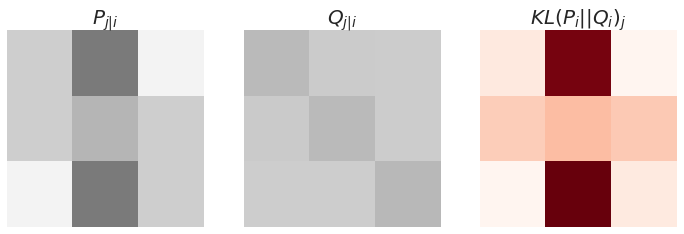

In [11]:
def kl_divergence_ij(p_ij: torch.Tensor, q_ij: torch.Tensor):
    return (p_ij * (p_ij.log() - q_ij.log()))

kl_ij = kl_divergence_ij(torch.from_numpy(p_ij), q_ij)

f, (left, middle, right) = plt.subplots(1, 3, figsize=(12, 8))

plot_matrix(p_ij, ax=left, title='$P_{j|i}$', vmin=0, vmax=1)
plot_matrix(q_ij, ax=middle, title='$Q_{j|i}$', vmin=0, vmax=1)
plot_matrix(kl_ij, ax=right, title='$ KL (P_i||Q_i)_{j}$', cmap='Reds')

kl_ij

### Derivating gradients

Replicating Annex A but for the SNE assymetric case

$$ q_{j|i} = \frac{ \exp ( - || y_i - y_j  ||^2) }{ \sum_{k\neq i} \exp ( - || y_i - y_k  ||^2) } $$ 

Defining intermediate variables:

$$ d_{ij} = ||y_i - y_j||^2 $$

$$ Z = \sum_{k\neq l} \exp ( - d_{kl}) $$

$$ \frac{\partial C}{\partial y_i} = \sum_j (\frac{\partial C}{\partial d_{ij}} + \frac{\partial C}{\partial d_{ji}}) (y_i - y_j) $$


From the KL definition (1st part constant):

$$ \frac{\partial C}{\partial d_{ij}} = - \sum_{k \neq l} p_{k|l} \frac{\partial (\log q_{k|l}) }{\partial d_{ij}} $$

$$ = - \sum_{k \neq l} p_{k|l} \frac{\partial (\log q_{k|l} Z - \log Z) }{\partial d_{ij}} $$

$$ = - \sum_{k \neq l} \Big( \underbrace{p_{k|l} \frac{\partial d_{kl}^2}{\partial d_{ij}}}_{1)} - \underbrace{ p_{k|l} Z^{-1} \frac{\partial Z}{\partial d_{ij}}}_{ 2) } \Big) $$

1) gradient $\frac{\partial d_{kl}^2}{\partial d_{ij}}$ only non-zero when $k=i$ and $l=j$

2) $Z^{-1} \frac{\partial Z}{\partial d_{ij}} = q_{i|j}$ and then $ \sum_{k\neq l} p_{k|l} = 1$

$$ \frac{\partial C}{\partial d_{ij}} = - 2 (p_{i|j} - q_{i|j}) $$

$$ \frac{\partial C}{\partial y_i} = 2\sum_j (p_{j|i} -  q_{j|i} + p_{i|j} - q_{i|j}) (yi - yj) $$

### Physical interpretation

"the gradient may be interpreted as the resultant force created by a set of springs between the map point $y_i$ and all other map points $y_j$ "

In [12]:
q_ij = approximated_probs(torch.from_numpy(y_i)).numpy()

spring_tensions_ij = (p_ij - q_ij + p_ij.T - q_ij.T)

gradients_ij = ((y_i - y_i[:, np.newaxis, :]) * spring_tensions_ij[:, :, np.newaxis])
print(gradients_ij.shape)
gradients_ij

(3, 3, 2)


array([[[-0.        , -0.        ],
        [-0.08440083, -0.09229355],
        [ 0.19392298, -0.04904546]],

       [[ 0.08440083,  0.09229355],
        [ 0.        ,  0.        ],
        [-0.04892448,  0.13235483]],

       [[-0.19392298,  0.04904546],
        [ 0.04892448, -0.13235483],
        [-0.        , -0.        ]]])

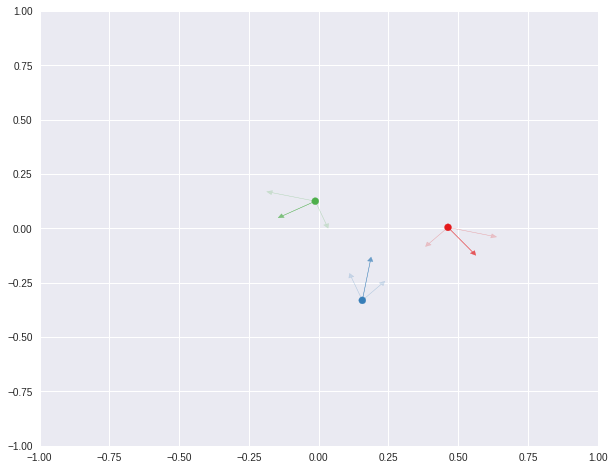

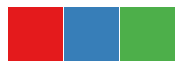

In [13]:
palette = sns.color_palette("Set1", np.max(points_to_clusters) + 1)

ax = plot(y_i, points_to_clusters);
arrow_params = dict(head_width=0.02, head_length=0.02)
n = p_ij.shape[0]
learning_rate = .8

gradients_i = gradients_ij.sum(axis=1)
for i in range(n):
    ax.arrow(*y_i[i], *learning_rate * gradients_i[i], color=palette[i], **arrow_params, alpha=.7)
    for j in set(range(n)).difference([i]):
        ax.arrow(*y_i[i], *learning_rate * gradients_ij[i][j], color=palette[i], **arrow_params, alpha=.2)

## Gradient through loss back-propagation

In [14]:
current_y_i = y_i

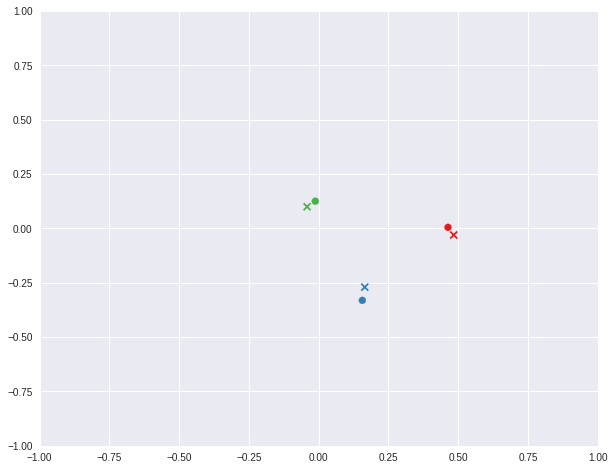

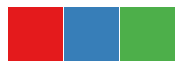

In [15]:
def updated_embeddings(current_y_i: np.array, p_ij: np.array, learning_rate=.2):
    embeddings_i = Variable(torch.from_numpy(current_y_i), requires_grad=True)
    
    loss = kl_divergence_ij(torch.from_numpy(p_ij), q_ij=approximated_probs(embeddings_i)).sum()

    loss.backward()
    embeddings_gradient_i = embeddings_i.grad.data.numpy()

    return current_y_i - learning_rate * embeddings_gradient_i

ax = plot(current_y_i, points_to_clusters)

current_y_i = updated_embeddings(current_y_i, p_ij)

plot(current_y_i, points_to_clusters, ax, marker='x')

## Illustration on a bigger dataset

$n$ individual data points spread accross 3 clusters, $p_ij$ depends on the cluster

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2])

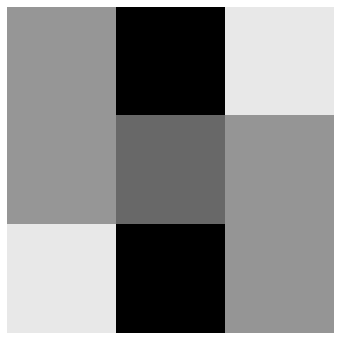

In [16]:
inter_p_ij = np.array(
    [[.3, .6, .1],
     [.3, .4, .3],
     [.1, .6, .3]])

n = 75
points_to_clusters = np.repeat([0, 1, 2], repeats=25)

p_ij = np.vstack([
    np.repeat(inter_p_ij[0], repeats=25),
    np.repeat(inter_p_ij[1], repeats=25),
    np.repeat(inter_p_ij[2], repeats=25)])[points_to_clusters]

p_ij = p_ij / p_ij.sum(1)

plot_matrix(p_ij, vmin=0)

points_to_clusters

In [17]:
y_i = np.random.normal(scale=.25, size=(n, d))
current_y_i = y_i

print(p_ij.shape)
print(current_y_i.shape)

(75, 75)
(75, 2)


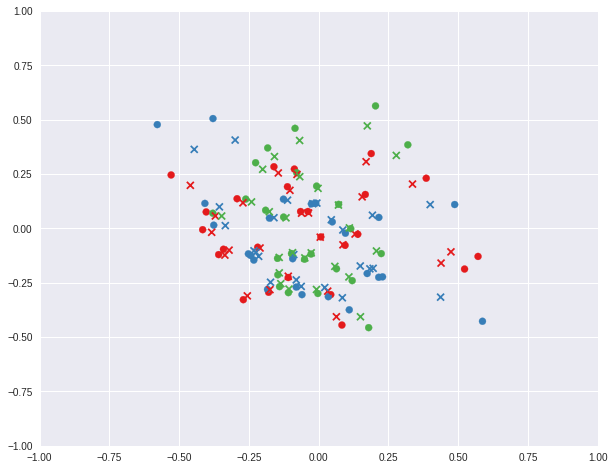

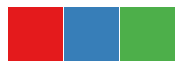

In [18]:
ax = plot(current_y_i, points_to_clusters)

updated_y_i = updated_embeddings(current_y_i, p_ij)

plot(updated_y_i, points_to_clusters, ax, marker='x')

current_y_i = updated_y_i

## Les Misérables' characters co-appearances

https://bost.ocks.org/mike/miserables/

In [19]:
! rm *
! wget https://gephi.org/datasets/lesmiserables.gml.zip
! unzip lesmiserables.gml.zip

import networkx as nx

G = nx.read_gml('lesmiserables.gml')

list(G.edges.items())[:10]

rm: cannot remove 'datalab': Is a directory
--2018-05-18 12:11:51--  https://gephi.org/datasets/lesmiserables.gml.zip
Resolving gephi.org (gephi.org)... 104.27.140.223, 104.27.141.223, 2400:cb00:2048:1::681b:8ddf, ...
Connecting to gephi.org (gephi.org)|104.27.140.223|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2102 (2.1K) [application/zip]
Saving to: ‘lesmiserables.gml.zip’

lesmiserables.gml.z 100%[===================>]   2.05K  --.-KB/s    in 0s      

2018-05-18 12:11:51 (19.1 MB/s) - ‘lesmiserables.gml.zip’ saved [2102/2102]

Archive:  lesmiserables.gml.zip
  inflating: lesmiserables.gml       


[(('Myriel', 'Napoleon'), {'value': 1}),
 (('Myriel', 'MlleBaptistine'), {'value': 8}),
 (('Myriel', 'MmeMagloire'), {'value': 10}),
 (('Myriel', 'CountessDeLo'), {'value': 1}),
 (('Myriel', 'Geborand'), {'value': 1}),
 (('Myriel', 'Champtercier'), {'value': 1}),
 (('Myriel', 'Cravatte'), {'value': 1}),
 (('Myriel', 'Count'), {'value': 2}),
 (('Myriel', 'OldMan'), {'value': 1}),
 (('Myriel', 'Valjean'), {'value': 5})]

In [20]:
from scipy import sparse


characters = list(G.nodes.keys())
character_to_indexes = {character: index for index, character in enumerate(characters)}

from_to_counts = [(character_to_indexes[first_character], character_to_indexes[second_character], attributes['value']) for (first_character, second_character), attributes in G.edges.items()]
froms, tos, counts = zip(*from_to_counts)

In [21]:
import pandas as pd

co_appearances_ij = sparse.coo_matrix((counts + counts, (froms + tos, tos + froms)), shape=(len(character_to_indexes), len(character_to_indexes)))

some_characters = np.array(['Javert', 'Valjean', 'Cosette', 'MmeThenardier', 'Zephine', 'Marius'])

pd.DataFrame(
    index=characters,
    columns=characters,
    data=co_appearances_ij.toarray()).loc[some_characters, some_characters]

,Javert,Valjean,Cosette,MmeThenardier,Zephine,Marius
Javert,0,17,1,1,0,0
Valjean,17,0,31,7,0,19
Cosette,1,31,0,4,0,21
MmeThenardier,1,7,4,0,0,0
Zephine,0,0,0,0,0,0
Marius,0,19,21,0,0,0


In [22]:
p_co_appearances_ij = co_appearances_ij / co_appearances_ij.sum(axis=1)

n = len(characters)
points_to_clusters = np.zeros_like(characters, dtype=int)

for character_index, character in enumerate(some_characters):
  points_to_clusters[character_to_indexes[character]] = character_index + 1
  
current_y_i = np.random.normal(scale=.25, size=(n, d))

['Javert' 'Valjean' 'Cosette' 'MmeThenardier' 'Zephine' 'Marius']


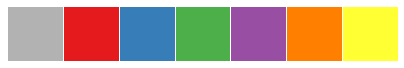

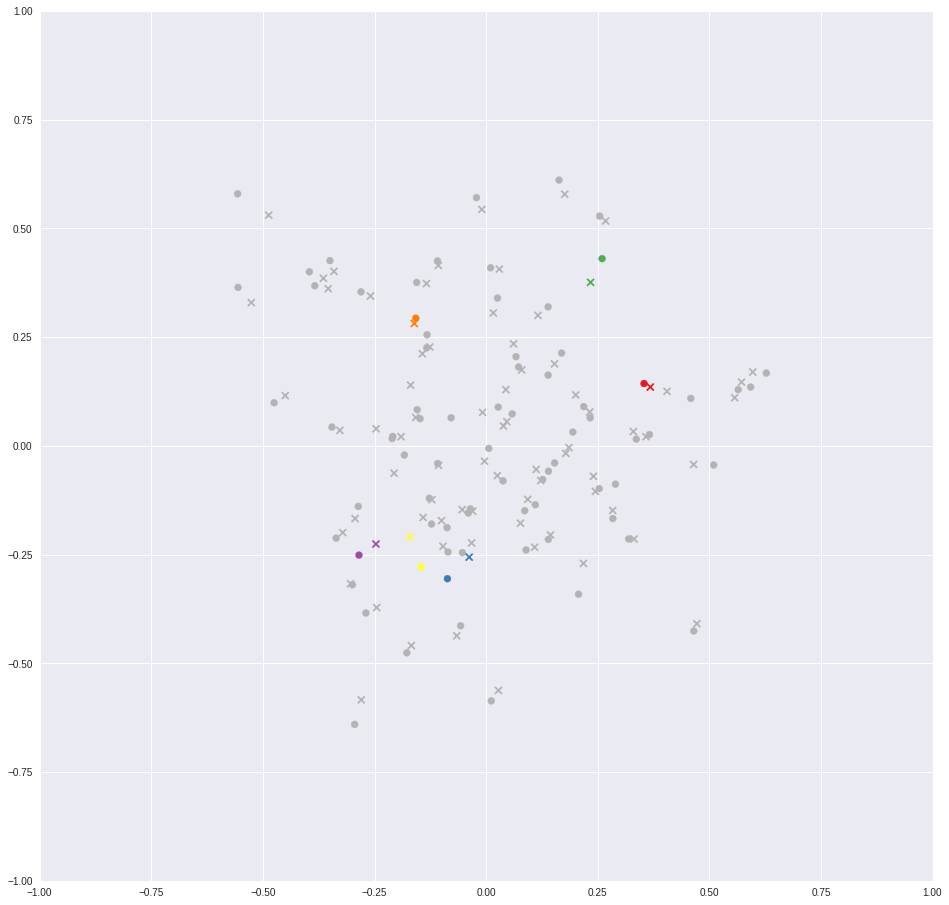

In [23]:
palette = [(.7, .7, .7)] + sns.color_palette("Set1", len(some_characters))
sns.palplot(palette)

f, ax = plt.subplots(1, figsize=(16, 16))


plot(current_y_i, points_to_clusters, ax, palette=palette)

updated_y_i = updated_embeddings(current_y_i, p_co_appearances_ij, learning_rate=.05)

plot(updated_y_i, points_to_clusters, ax, marker='x', palette=palette)
    
current_y_i = updated_y_i

print(some_characters)


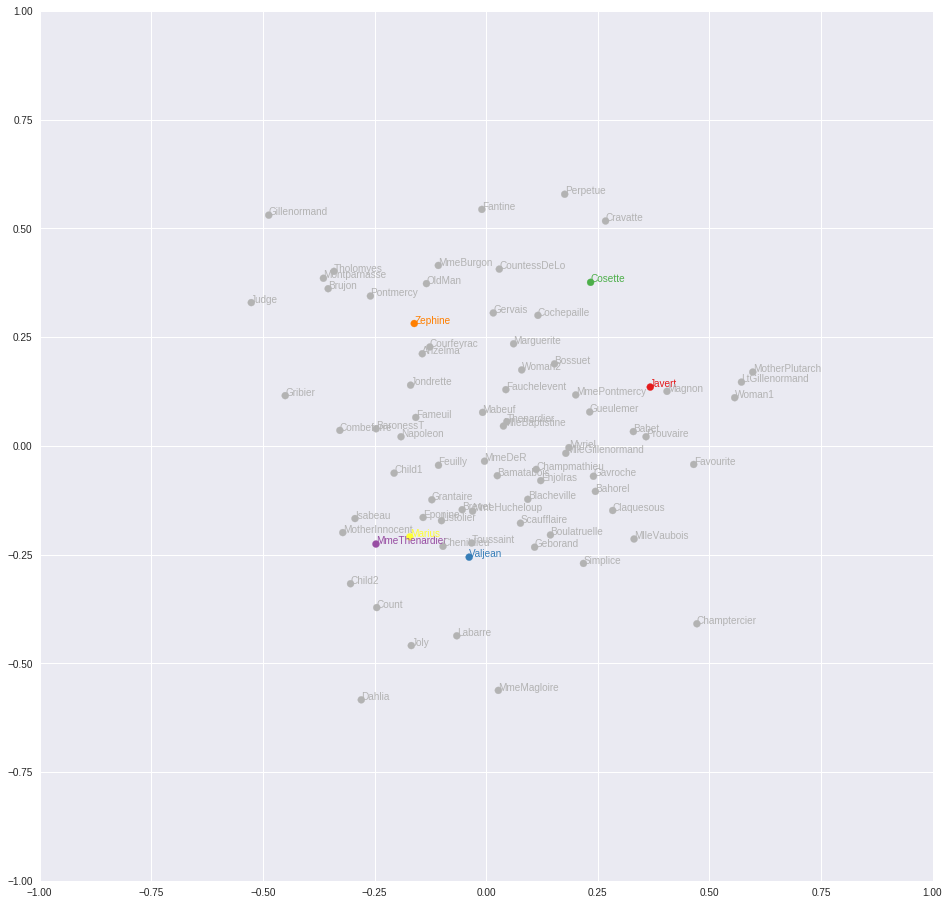

In [24]:
f, ax = plt.subplots(1, figsize=(16, 16))

plot(current_y_i, points_to_clusters, ax, palette=palette)

for name, xy in zip(characters, current_y_i):
  ax.text(*xy, s=name, color=palette[points_to_clusters[character_to_indexes[name]]])